# DeepLabCut Ingestion/Inference

# DeepLabCut manual:
https://github.com/DeepLabCut/DeepLabCut/blob/main/docs/standardDeepLabCut_UserGuide.md

`Dev notes:` Currently, the path structure assumes you have one DLC project directory for all models, as specified within `adamacs.pipeline.get_dlc_root_data_dir`. The parallel function `get_dlc_processed_data_dir` can specify the output directory. 

## TODO

1. Have the DLC model as selector in the Pingest GUI (model.Model() = model_name)
2. Add a checkbox to process DLC data
3. model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True}, task_mode = 'trigger') - have additional options in table?
4. model.RecordingInfo.populate()
model.RecordingInfo()
5. model.PoseEstimation.populate()
6. defer population to tmux or cron jobs?


## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

[2023-09-20 12:15:17,983][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-09-20 12:15:18,031][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

In [2]:
dj.config["custom"].get("dlc_root_data_dir")


['/datajoint-data/models/tobiasr/DB_DLC_tracking',
 '/datajoint-data/models/tobiasr/NK_DLC_tracking',
 '/']

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates items.

In [3]:
from adamacs.pipeline import subject, train,  scan, event, trial, behavior, session, model, equipment, imaging

## Ingesting videos and training parameters

### Automated

Refer the `user_data` folder in the `adamacs` directory contains CSVs for inserting values into DeepLabCut tables.

1. `config_params.csv` is used for training parameter sets in `train.TrainingParamSet`. The following items are required, but others will also be passed to DLC's `train_network` function when called 
2. `train_videosets.csv` and `model_videos.csv` pass values to `train.VideoSet` and `model.VideoRecording` respectively.
3. `adamacs.ingest.dlc.ingest_dlc_items` will load each of these CSVs

For more information, see [this notebook](https://github.com/CBroz1/workflow-deeplabcut/blob/main/notebooks/04-Automate_Optional.ipynb)

In [4]:
    # from adamacs.ingest.dlc import ingest_dlc_items
    # ingest_dlc_items()

In [ ]:
# model.VideoRecording().delete()
# model.Model.delete()

In [5]:
train.schema.list_tables()

['video_set',
 'video_set__file',
 '#training_param_set',
 'training_task',
 '__model_training']

### Manual

The same training parameters as above can be manually inserted as follows.

In [19]:
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir
import pathlib
# config_path = find_full_path(get_dlc_root_data_dir(), 
                            #  'from_top_tracking-DJ-2022-02-23/config.yaml')
config_path = find_full_path(get_dlc_root_data_dir(), 
                             'Topcam_2bin_wtscope-NK-2023-09-11/config.yaml')

In [20]:
model.VideoRecording.File()

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FHDA7AI,scan9FHDA7AI,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-03_scan9FHDA7AI_sess9FHDA7AI/scan9FHDA7AI_top_video_2023-03-31T16_04_25.mp4
sess9FHDA7AI,scan9FHDADB9,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-03_scan9FHDADB9_sess9FHDA7AI/scan9FHDADB9_top_video_2023-03-31T16_04_25.mp4
sess9FHELAYA,scan9FHELAYA,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
sess9FHELAYA,scan9FHELMRY,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4
sess9FHELAYA,scan9FHELX2S,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_top_video_2023-04-05T16_01_14.mp4
sess9FHELAYA,scan9FHEMBE2,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4
sess9FHS7Y22,scan9FHS7Y22,0,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22/scan9FHS7Y22_top_video_2023-04-28T12_42_12.mp4
sess9FHS7Y22,scan9FHS845A,0,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22/scan9FHS845A_top_video_2023-04-28T12_53_47.mp4
sess9FI3KWP3,scan9FI3KWP3,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-05-17_scan9FI3KWP3_sess9FI3KWP3/scan9FI3KWP3_top_video_2023-05-17T14_38_34.mp4
sess9FI3KWP3,scan9FI3L5PZ,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-05-17_scan9FI3L5PZ_sess9FI3KWP3/scan9FI3L5PZ_top_video_2023-05-17T14_55_15.mp4


In [ ]:
scansi = "scan9FJ842C3"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 0})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FB2LN5C"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 1})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FHELAYA"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*copy*.mp4"))[0])
# moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4-copy.mp4"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 2})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
model.VideoRecording() * model.VideoRecording.File() * equipment.Device()

## Model Training

The `TrainingTask` table queues up training. To launch training from a different machine, one needs to edit DLC's config files to reflect updated paths. For training, this includes `dlc-models/*/*/train/pose_cfg.yaml`

`CB DEV NOTE:` I'm missing the following videos used to originally train the model:
- top_video2022-02-17T15_56_10.mp4
- top_video2022-02-21T12_18_09.mp4

#### DeepLabcut Tables

The `VideoSet` table in the `train` schema retains records of files generated in the video labeling process (e.g., `h5`, `csv`, `png`). DeepLabCut will refer to the `mat` file located under the `training-datasets` directory.

We recommend storing all paths as relative to the root in your config.

In [5]:
# train.VideoSet.delete()

In [21]:
train.VideoSet.insert1({'video_set_id': 0}, skip_duplicates=True)
project_folder = 'from_top_tracking-DJ-2022-02-23/'
training_files = ['labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png',
                  'videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 0,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

video_set_id,file_id,file_path
0,0,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5
0,1,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv
0,2,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png
0,3,from_top_tracking-DJ-2022-02-23/videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4
1,0,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5
1,1,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv
1,2,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png
1,3,Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4


In [22]:
train.VideoSet.insert1({'video_set_id': 1}, skip_duplicates=True)
project_folder = 'Head_orientation-NK-2023-07-17/'
training_files = ['labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png',
                  'videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 1,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

video_set_id,file_id,file_path
0,0,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5
0,1,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv
0,2,from_top_tracking-DJ-2022-02-23/labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png
0,3,from_top_tracking-DJ-2022-02-23/videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4
1,0,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5
1,1,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv
1,2,Head_orientation-NK-2023-07-17/labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png
1,3,Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4


In [23]:
train.VideoSet.delete()

[2023-09-20 12:20:23,712][INFO]: Deleting 2 rows from `tobiasr_train`.`training_task`
[2023-09-20 12:20:23,716][INFO]: Deleting 8 rows from `tobiasr_train`.`video_set__file`
[2023-09-20 12:20:23,719][INFO]: Deleting 2 rows from `tobiasr_train`.`video_set`
[2023-09-20 12:20:27,057][WARNING]: Deletes cancelled


2

The `params` longblob should be a dictionary that captures all items for DeepLabCut's `train_network` function. At minimum, this is the contents of the project's config file, as well as `suffle` and `trainingsetindex`, which are not included in the config. 

In [24]:
from deeplabcut import train_network
help(train_network) # for more information on optional parameters

Help on function train_network in module deeplabcut.pose_estimation_tensorflow.training:

train_network(config, shuffle=1, trainingsetindex=0, max_snapshots_to_keep=5, displayiters=None, saveiters=None, maxiters=None, allow_growth=True, gputouse=None, autotune=False, keepdeconvweights=True, modelprefix='')
    Trains the network with the labels in the training dataset.
    
    Parameters
    ----------
    config : string
        Full path of the config.yaml file as a string.
    
    shuffle: int, optional, default=1
        Integer value specifying the shuffle index to select for training.
    
    trainingsetindex: int, optional, default=0
        Integer specifying which TrainingsetFraction to use.
        Note that TrainingFraction is a list in config.yaml.
    
    max_snapshots_to_keep: int or None
        Sets how many snapshots are kept, i.e. states of the trained network. Every
        saving iteration many times a snapshot is stored, however only the last
        ``max_snap

Here, we give these items, load the config contents, and overwrite some defaults, including `maxiters`, to restrict our training iterations to 5.

In [25]:
train.TrainingParamSet()

paramset_idx,paramset_desc,param_set_hash hash identifying this parameterset,params dictionary of all applicable parameters
0,from_top_tracking-DJ-2022-02-23,d5736a15-23a7-5469-c521-6929b5f1d1b7,=BLOB=
1,Head_orientation-NK-2023-07-17,c6ec66ba-91f0-b916-fcbd-6dcf9f5adc23,=BLOB=


In [26]:
import yaml

paramset_idx = 0; paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [27]:
paramset_idx = 1; paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [51]:
paramset_idx = 2; paramset_desc='Topcam_2bin_wtscope-NK-2023-09-11'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [52]:
train.TrainingParamSet()

paramset_idx,paramset_desc,param_set_hash hash identifying this parameterset,params dictionary of all applicable parameters
0,from_top_tracking-DJ-2022-02-23,d5736a15-23a7-5469-c521-6929b5f1d1b7,=BLOB=
1,Head_orientation-NK-2023-07-17,c6ec66ba-91f0-b916-fcbd-6dcf9f5adc23,=BLOB=
2,Topcam_2bin_wtscope-NK-2023-09-11,68b7d500-347d-c656-1537-1dec4146e42e,=BLOB=


In [29]:
# train.TrainingTask.delete()

In [30]:
key={'video_set_id': 0, 
     'paramset_idx':0,
     'training_id':0, # uniquely defines training task
     'project_path':'from_top_tracking-DJ-2022-02-23/' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

video_set_id,paramset_idx,training_id,model_prefix,project_path DLC's project_path in config relative to root
0,0,0,,from_top_tracking-DJ-2022-02-23/
1,1,1,,Head_orientation-NK-2023-07-17


In [31]:
key={'video_set_id': 1, 
     'paramset_idx':1,
     'training_id':1, # uniquely defines training task
     'project_path':'Head_orientation-NK-2023-07-17' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

video_set_id,paramset_idx,training_id,model_prefix,project_path DLC's project_path in config relative to root
0,0,0,,from_top_tracking-DJ-2022-02-23/
1,1,1,,Head_orientation-NK-2023-07-17


In [32]:
(train.TrainingParamSet & "paramset_idx=1").fetch("params")

array([{'Task': 'Head_orientation', 'scorer': 'NK', 'date': 'Jul17', 'multianimalproject': 'False', 'identity': None, 'bodyparts': ['left_ear', 'right_ear', 'nose', 'head_middle', 'neck', 'body_middle', 'tail'], 'start': 0, 'stop': 1, 'numframes2pick': 100, 'skeleton': [['bodypart1', 'bodypart2'], ['objectA', 'bodypart3']], 'skeleton_color': 'black', 'pcutoff': 0.6, 'dotsize': 12, 'alphavalue': 0.7, 'colormap': 'rainbow', 'TrainingFraction': [0.95], 'iteration': 0, 'default_net_type': 'resnet_50', 'default_augmenter': 'default', 'snapshotindex': 3, 'batch_size': 8, 'cropping': False, 'x1': 0, 'x2': 640, 'y1': 277, 'y2': 624, 'corner2move2': [50, 50], 'move2corner': True, 'shuffle': '1', 'trainingsetindex': '0', 'maxiters': '5', 'scorer_legacy': 'False'}],
      dtype=object)

In [35]:
# (train.TrainingTask() & ("video_set_id = 1")).delete()
train.TrainingTask()

video_set_id,paramset_idx,training_id,model_prefix,project_path DLC's project_path in config relative to root
0,0,0,,from_top_tracking-DJ-2022-02-23/
1,1,1,,Head_orientation-NK-2023-07-17


In [50]:
train.ModelTraining.populate()

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['head', 'bodycenter', 'tailbase'],
 'alpha_r': 0.02,
 'apply_prob': 0.5,
 'batch_size': 1,
 'clahe': True,
 'claheratio': 0.1,
 'crop_pad': 0,
 'crop_sampling': 'hybrid',
 'crop_size': [400, 400],
 'cropratio': 0.4,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_from_top_trackingFeb23\\from_top_tracking_DJ95shuffle1.mat',
 'dataset_type': 'imgaug',
 'decay_steps': 30000,
 'deterministic': False,
 'display_iters': 1000,
 'edge': False,
 'emboss': {'alpha': [0.0, 1.0], 'embossratio': 0.1, 'strength': [0.5, 1.5]},
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'histeq': True,
 'histeqratio': 0.1,
 'init_weights': 'C:\\Users\\mini2p_1_aux\\.conda\\envs\\DEEPLABCUT_GPU\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\mobilenet_v2_1.0_224.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref

Selecting single-animal trainer


FileNotFoundError: [Errno 2] No such file or directory: '/datajoint-data/models/tobiasr/DB_DLC_tracking/from_top_tracking-DJ-2022-02-23/training-datasets\\iteration-0\\UnaugmentedDataSet_from_top_trackingFeb23\\from_top_tracking_DJ95shuffle1.mat'

To start training from a previous instance, one would need to 
[edit the relevant config file](https://github.com/DeepLabCut/DeepLabCut/issues/70) and
adjust the `maxiters` paramset (if present) to a higher threshold (e.g., 10 for 5 more itterations).
Emperical work from the Mathis team suggests 200k iterations for any true use-case.

## Tracking Joints/Body Parts

The `model` schema uses a lookup table for managing Body Parts tracked across models.

In [5]:
model.Model()

model_name User-friendly model name,task Task in the config yaml,date Date in the config yaml,iteration Iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle Shuffle (1) or not (0),trainingsetindex Index of training fraction list in config.yaml,scorer Scorer/network name - DLC's GetScorerName(),config_template Dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
Head_orientation-NK,Head_orientation,Jul17,0,3,1,0,DLC_resnet50_Head_orientationJul17shuffle1_90000,=BLOB=,Head_orientation-NK-2023-07-17,,"From Top, trained 5 iterations",1


In [6]:
model.BodyPart.heading

body_part            : varchar(32)                  # 
---
body_part_description="" : varchar(1000)                # 

This table is equipped with two helper functions. First, we can identify all the new body parts from a given config file.

In [37]:
from adamacs.paths import get_dlc_root_data_dir
config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')
model.BodyPart.extract_new_body_parts(config_path)

Existing body parts: ['body_middle' 'head_middle' 'left_ear' 'neck' 'nose' 'right_ear' 'tail']
New body parts: []


array([], dtype='<U11')

Now, we can make a list of descriptions in the same order, and insert them into the table

In [38]:
model.BodyPart()

body_part,body_part_description
body_middle,
head_middle,
left_ear,
neck,
nose,
right_ear,
tail,


In [39]:
# Will be inserted with model insertion
# bp_desc=['Body Center', 'Head', 'Base of Tail']
# model.BodyPart.insert_from_config(config_path,bp_desc)

If we skip this step, body parts (without descriptions) will be added when we insert a model. We can [update](https://docs.datajoint.org/python/v0.13/manipulation/3-Cautious-Update.html) empty descriptions at any time.

## Declaring a Model

If training appears successful, the result can be inserted into the `Model` table for automatic evaluation.

In [40]:
paramset_desc='from_top_tracking-DJ-2022-02-23'
# paramset_desc='Topcam_2bin_wtscope-NK-2023-09-11'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

In [41]:
model.Model.insert_new_model(model_name='from_top_tracking-DJ',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=0)

FileNotFoundError: No valid full-path found (from ['/datajoint-data/models/tobiasr/DB_DLC_tracking', '/datajoint-data/models/tobiasr/NK_DLC_tracking', '/']) for /datajoint-data/data/tobiasr/DeepLabCutModels/DB_DLC_tracking/from_top_tracking-DJ-2022-02-23

In [42]:
# paramset_desc='Head_orientation-NK-2023-07-17'
paramset_desc='Topcam_2bin_wtscope-NK-2023-09-11'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

In [43]:
config_path

PosixPath('/datajoint-data/models/tobiasr/NK_DLC_tracking/Topcam_2bin_wtscope-NK-2023-09-11/config.yaml')

In [49]:
model.Model.insert_new_model(model_name=paramset_desc,dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, mouse without anything',
                             paramset_idx=1)

--- DLC Model specification to be inserted ---
	model_name: Topcam_2bin_wtscope-NK-2023-09-11
	model_description: From Top, mouse without anything
	scorer: DLC_resnet50_Topcam_2bin_wtscopeSep11shuffle1_130000
	task: Topcam_2bin_wtscope
	date: Sep11
	iteration: 0
	snapshotindex: -3
	shuffle: 1
	trainingsetindex: 0
	project_path: Topcam_2bin_wtscope-NK-2023-09-11
	paramset_idx: 1
	-- Template/Contents of config.yaml --
		Task: Topcam_2bin_wtscope
		scorer: NK
		date: Sep11
		multianimalproject: False
		identity: None
		project_path: /datajoint-data/models/tobiasr/NK_DLC_tracking/Topcam_2bin_wtscope-NK-2023-09-11
		video_sets: {'C:\\Git\\DeepLabCut\\Projects\\Topcam_2bin_wtscope-NK-2023-09-11\\videos\\scan9FJZH7V8_top_video_2023-09-08T15_43_50.mp4': {'crop': '0, 500, 0, 500'}, 'C:\\Git\\DeepLabCut\\Projects\\Topcam_2bin_wtscope-NK-2023-09-11\\videos\\scan9FJU4MXH_top_video_2023-08-30T16_05_36.mp4': {'crop': '0, 500, 0, 500'}, 'C:\\Git\\DeepLabCut\\Projects\\Topcam_2bin_wtscope-NK-2023-09-

In [13]:
model.Model()

model_name User-friendly model name,task Task in the config yaml,date Date in the config yaml,iteration Iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle Shuffle (1) or not (0),trainingsetindex Index of training fraction list in config.yaml,scorer Scorer/network name - DLC's GetScorerName(),config_template Dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
Head_orientation-NK,Head_orientation,Jul17,0,3,1,0,DLC_resnet50_Head_orientationJul17shuffle1_90000,=BLOB=,Head_orientation-NK-2023-07-17,,"From Top, trained 5 iterations",1


In [6]:
model.VideoRecording * model.VideoRecording.File() * session.SessionUser * subject.User() * session.Session() * scan.ScanInfo * scan.ScanInfo.Field()

session_id,recording_id,file_id,user_id,scan_id,field_idx,camera,"file_path filepath of video, relative to root data directory",name,shorthand TR: added name_FirstInitialSurname shorthand,initials Update after pyrat ingestion,email TR: for completeness' sake also email,"lab short lab name, pyrat labid",subject PyRat import uses this for earmark value,session_datetime,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,zoom scan zoom factor,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHELAYA,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHELMRY,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHELX2S,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELAYA,0,7,scan9FHEMBE2,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELMRY,0,7,scan9FHELAYA,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00:00,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELMRY,0,7,scan9FHELMRY,0,mini2p1_top,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4,Narayanamurthy Rukhmani,rukhun,RN,rnar@uni-bonn.de,Rose,OPI-1681,2023-04-05 00:00

In [10]:
model.Model().fetch("config_template")

array([{'Task': 'Head_orientation', 'scorer': 'NK', 'date': 'Jul17', 'multianimalproject': False, 'identity': None, 'project_path': '/datajoint-data/models/tobiasr/NK_DLC_tracking/Head_orientation-NK-2023-07-17', 'video_sets': {'/datajoint-data/models/tobiasr/DeepLabCutModels/NK_DLC_tracking/Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4': {'crop': '0, 1000, 0, 1000'}}, 'bodyparts': ['left_ear', 'right_ear', 'nose', 'head_middle', 'neck', 'body_middle', 'tail'], 'start': 0, 'stop': 1, 'numframes2pick': 100, 'skeleton': [['bodypart1', 'bodypart2'], ['objectA', 'bodypart3']], 'skeleton_color': 'black', 'pcutoff': 0.6, 'dotsize': 12, 'alphavalue': 0.7, 'colormap': 'rainbow', 'TrainingFraction': [0.95], 'iteration': 0, 'default_net_type': 'resnet_50', 'default_augmenter': 'default', 'snapshotindex': 3, 'batch_size': 8, 'cropping': False, 'x1': 0, 'x2': 640, 'y1': 277, 'y2': 624, 'corner2move2': [50, 50], 'move2corner': True}],
      dtype=object)

In [ ]:
model.Model.BodyPart()

## Model Evaluation

Next, all inserted models can be evaluated with a similar `populate` method, which will
insert the relevant output from DLC's `evaluate_network` function.

In [12]:
model.ModelEvaluation.heading

# 
model_name           : varchar(64)                  # User-friendly model name
---
train_iterations     : int                          # Training iterations
train_error=null     : float                        # Train error (px)
test_error=null      : float                        # Test error (px)
p_cutoff=null        : float                        # p-cutoff used
train_error_p=null   : float                        # Train error with p-cutoff
test_error_p=null    : float                        # Test error with p-cutoff

In [13]:
model.ModelEvaluation.populate()

2023-08-01 12:51:09.726406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 12:51:09.877550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-08-01 12:51:09.877571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-01 12:51:09.910958: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already 

Loading DLC 2.3.4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Running  DLC_resnet50_Head_orientationJul17shuffle1_90000  with # of training iterations: 90000
This net has already been evaluated!


If your project was initialized in a version of DeepLabCut other than the one you're currently using, model evaluation may report key errors. Specifically, your `config.yaml` may not specify `multianimalproject: false`.

In [14]:
model.ModelEvaluation()

model_name User-friendly model name,train_iterations Training iterations,train_error Train error (px),test_error Test error (px),p_cutoff p-cutoff used,train_error_p Train error with p-cutoff,test_error_p Test error with p-cutoff
Head_orientation-NK,100000,3.12,3.19,0.6,3.12,3.19


In [15]:
model.RecordingInfo.populate()
model.RecordingInfo() * model.VideoRecording.File()

session_id,recording_id,file_id,px_height height in pixels,px_width width in pixels,nframes number of frames,fps (Hz) frames per second,recording_datetime Datetime for the start of the recording,recording_duration video duration (s) from nframes / fps,"file_path filepath of video, relative to root data directory"
sess9FHELAYA,scan9FHELAYA,0,1000,1000,36162,60,None,602.7,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
sess9FHELAYA,scan9FHELMRY,0,1000,1000,36171,60,None,602.85,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4
sess9FHELAYA,scan9FHELX2S,0,1000,1000,36189,60,None,603.15,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_top_video_2023-04-05T16_01_14.mp4
sess9FHELAYA,scan9FHEMBE2,0,1000,1000,36162,60,None,602.7,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4
sess9FJBPNSP,scan9FJBPNSP,0,1000,1000,36337,60,None,605.617,/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/scan9FJBPNSP_top_video_2023-07-30T17_38_30.mp4


## Pose Estimation

In [5]:
scansi = "scan9FHELAYA"
scan_key = (model.VideoRecording.File & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4'],
      dtype=object)

In [6]:
model.VideoRecording.File()

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FHELAYA,scan9FHELAYA,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
sess9FHELAYA,scan9FHELMRY,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4
sess9FHELAYA,scan9FHELX2S,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_top_video_2023-04-05T16_01_14.mp4
sess9FHELAYA,scan9FHEMBE2,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4
sess9FHS7Y22,scan9FHS7Y22,0,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22/scan9FHS7Y22_top_video_2023-04-28T12_42_12.mp4
sess9FHS7Y22,scan9FHS845A,0,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22/scan9FHS845A_top_video_2023-04-28T12_53_47.mp4
sess9FIG39RU,scan9FIG39RU,0,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG39RU_sess9FIG39RU/scan9FIG39RU_top_video_2023-06-07T15_01_05.mp4
sess9FIG39RU,scan9FIG3GCJ,0,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3GCJ_sess9FIG39RU/scan9FIG3GCJ_top_video_2023-06-07T15_13_23.mp4
sess9FIG39RU,scan9FIG3MU8,0,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3MU8_sess9FIG39RU/scan9FIG3MU8_top_video_2023-06-07T15_20_34.mp4
sess9FJ1IJYT,scan9FJ1IJYT,0,/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-13_scan9FJ1IJYT_sess9FJ1IJYT/scan9FJ1IJYT_top_video_2023-07-13T14_34_31.mp4


For demonstration purposes, we'll make a shorter video that will process relatively quickly `ffmpeg`, a DLC dependency ([more info here](https://github.com/datajoint/workflow-deeplabcut/blob/main/notebooks/00-DataDownload_Optional.ipynb))

In [13]:
from adamacs.paths import get_dlc_root_data_dir
vid_path =  find_full_path(get_dlc_root_data_dir(), path[0][1::])
print(vid_path)
starttime = 0
duration = 10
cmd = (f'ffmpeg -n -hide_banner -loglevel error -ss {starttime} -t {duration} -i {vid_path} '
       + f'-vcodec copy -acodec copy {vid_path}-copy.mp4')
import os; os.system(cmd)

/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4


0

In [ ]:
model.VideoRecording.delete()

Next, we need to specify if the `PoseEstimation` table should load results from an existing file or trigger the estimation command. Here, we can also specify parameters accepted by the `analyze_videos` function as a dictionary. `task_mode` determines if pose estimation results should be loaded or triggered (i.e., load vs. trigger).

In [7]:
key = (model.VideoRecording & {'recording_id': 'scan9FHELAYA'}).fetch1('KEY')
key.update({'model_name': 'Head_orientation-NK', 'task_mode': 'trigger'})
key



{'session_id': 'sess9FHELAYA',
 'recording_id': 'scan9FHELAYA',
 'model_name': 'Head_orientation-NK',
 'task_mode': 'trigger'}

The `PoseEstimationTask` table queues items for pose estimation. Additional parameters are passed to DLC's `analyze_videos` function.

In [16]:
model.PoseEstimationTask()

session_id,recording_id,model_name User-friendly model name,task_mode load results or trigger computation,pose_estimation_output_dir output dir relative to the root dir,"pose_estimation_params analyze_videos params, if not default"
sess9FHELAYA,scan9FHELAYA,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELAYA_model_Head_orientation-NK,=BLOB=
sess9FHELAYA,scan9FHELMRY,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELMRY_model_Head_orientation-NK,=BLOB=
sess9FHELAYA,scan9FHELX2S,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELX2S_model_Head_orientation-NK,=BLOB=
sess9FHELAYA,scan9FHEMBE2,Head_orientation-NK,load,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/device_mini2p1_top_recording_scan9FHEMBE2_model_Head_orientation-NK,=BLOB=
sess9FJBPNSP,scan9FJBPNSP,Head_orientation-NK,load,/datajoint-data/data/tobiasr/JJ_WEZ-8873_2023-07-30_scan9FJBPNSP_sess9FJBPNSP/device_mini2p1_top_recording_scan9FJBPNSP_model_Head_orientation-NK,=BLOB=


In [ ]:
train.ModelTraining()

In [ ]:
# model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True})
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,100)}) # dynamic cropping

In [ ]:
model.RecordingInfo.populate()
model.RecordingInfo()

In [17]:
model.PoseEstimation.populate()

In [ ]:
model.PoseEstimationTask().delete()
model.PoseEstimation().delete()

# Data Evaluation

By default, DataJoint will store the results of pose estimation in a subdirectory
>  processed_dir / videos / device_<#>_recording_<#>_model_<name>

Pulling processed_dir from `get_dlc_processed_dir`, and device/recording information 
from the `VideoRecording` table. The model name is taken from the primary key of the
`Model` table, with spaced replaced by hyphens.
    
We can get this estimation directly as a pandas dataframe.

In [ ]:
(model.PoseEstimation() * session.Session * session.SessionUser * subject.User()).fetch(format = "frame", order_by = "session_datetime")

In [8]:
scansi = "scan9FHELAYA"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4'],
      dtype=object)

In [9]:
imaging.Curation()

session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
sess9FH37WBZ,scan9FH37WBZ,0,1,2023-08-01 12:32:53,/datajoint-data/data/tobiasr/JJ_ROS-1487_2023-03-17_scan9FH37WBZ_sess9FH37WBZ,0,
sess9FHELAYA,scan9FHELAYA,0,1,2023-08-01 12:52:12,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA,0,
sess9FHELAYA,scan9FHELMRY,0,1,2023-08-01 12:53:27,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA,0,
sess9FHELAYA,scan9FHELX2S,0,1,2023-08-01 12:54:55,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA,0,
sess9FHELAYA,scan9FHEMBE2,0,1,2023-08-01 12:56:24,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA,0,
sess9FHS7Y22,scan9FHS7Y22,0,1,2023-08-01 13:05:53,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22,0,
sess9FHS7Y22,scan9FHS845A,0,1,2023-08-01 13:06:59,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22,0,
sess9FIG39RU,scan9FIG39RU,0,1,2023-08-01 13:07:36,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG39RU_sess9FIG39RU,0,
sess9FIG39RU,scan9FIG3GCJ,0,1,2023-08-01 13:08:18,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3GCJ_sess9FIG39RU,0,
sess9FIG39RU,scan9FIG3MU8,0,1,2023-08-01 13:09:30,/datajoint-data/data/tobiasr/NK_WEZ-8869_2023-06-07_scan9FIG3MU8_sess9FIG39RU,0,


In [10]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

[array([array([380.73884201, 374.84182262, 375.0663054 , ..., 651.86071575,
               652.10165882, 651.30563527])                                ],
       dtype=object),
 array([array([859.86421496, 863.01784873, 862.66774058, ..., 197.17555094,
               200.71034735, 200.05876011])                                ],
       dtype=object)]

In [11]:
#reduce dataframe to xy coordinates
df=model.PoseEstimation.get_trajectory(scan_key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['Head_orientation-NK']
# df_xy.mean()
df_xy

bodyparts body_middle             head_middle                left_ear   
coords              x           y           x           y           x   
0          460.246986  855.983541  380.738842  859.864215  393.243686  \
1          461.857650  857.070376  374.841823  863.017849  372.766590   
2          460.034508  858.582501  375.066305  862.667741  387.558141   
3          453.873499  856.929809  368.592979  860.128707  361.217901   
4          452.610700  859.226339  365.826214  863.547038  375.431343   
...               ...         ...         ...         ...         ...   
36157      658.226946  160.557538  652.933071  197.303982  672.733586   
36158      655.962129  159.669405  652.031765  198.772949  671.697992   
36159      654.446086  158.329220  651.860716  197.175551  670.772827   
36160      656.655265  159.915079  652.101659  200.710347  670.213625   
36161      656.272877  160.282261  651.305635  200.058760  670.247068   

bodyparts                    neck                    nose               
coords              y           x           y           x           y   
0          878.373095  396.091553  859.018027  354.869100  861.102093  \
1          877.567453  392.562470  863.966991  355.399848  867.101795   
2          881.745398  395.467882  861.935717  346.987713  863.795628   
3          872.030690  386.373099  860.844898  339.496748  863.447024   
4          883.022045  383.234733  865.503304  352.297114  851.588018   
...               ...         ...         ...         ...         ...   
36157      189.368509  658.799417  185.445288  637.115868  221.235262   
36158      189.734309  657.090601  186.168373  661.111862  216.187509   
36159      189.146574  657.518850  182.295532  658.381418  218.694144   
36160      188.696022  655.919428  186.509845  655.448543  219.009648   
36161      190.992655  655.606989  186.467777  656.508388  219.228965   

bodyparts   right_ear                    tail              
coords              x           y           x           y  
0          390.024394  845.088316  487.512999  861.669156  
1          391.885639  848.820122  485.897293  862.519579  
2          392.806077  849.276542  485.633356  865.277226  
3          383.382616  847.867819  482.709526  864.323121  
4          380.565590  850.576568  477.731924  865.230293  
...               ...         ...         ...         ...  
36157      640.472964  183.508404  647.644031  147.136736  
36158      635.205044  185.437511  640.358429  153.022447  
36159      634.332724  188.591030  645.631953  145.641745  
36160      635.380795  187.225661  646.403404  145.396095  
36161      634.506839  186.989117  639.412386  153.020960  

[36162 rows x 14 columns]

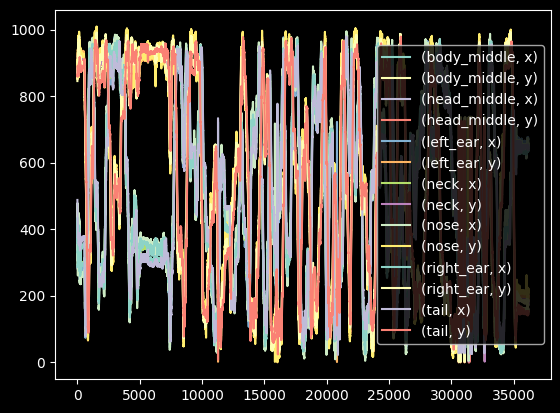

In [12]:
df_xy.plot().legend(loc='right')

In [13]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

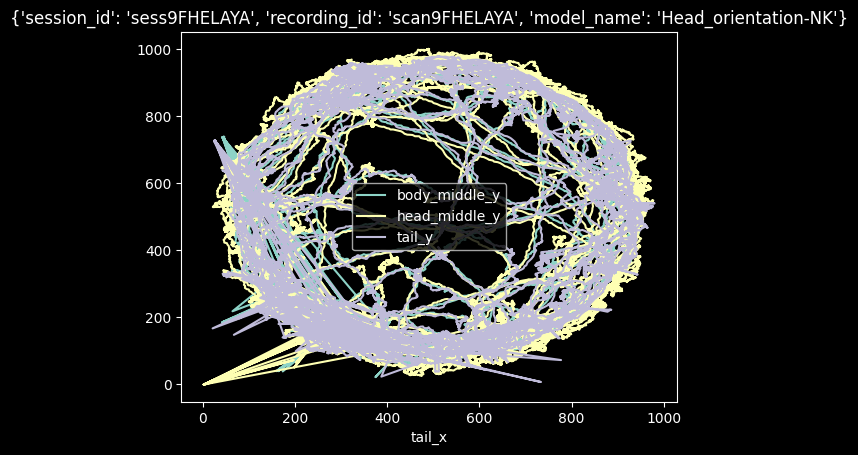

In [14]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots()
df_flat.plot(x='body_middle_x',y='body_middle_y',ax=ax)
df_flat.plot(x='head_middle_x',y='head_middle_y', ax=ax)
df_flat.plot(x='tail_x',y='tail_y', ax=ax)
plt.title(scan_key)
plt.show()

In [16]:
destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

PosixPath('/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELAYA_model_Head_orientation-NK')

In [17]:
key

{'session_id': 'sess9FHELAYA',
 'recording_id': 'scan9FHELAYA',
 'model_name': 'Head_orientation-NK',
 'task_mode': 'trigger'}

In [20]:
from deeplabcut.utils.make_labeled_video import create_labeled_video
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir


video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

Starting to process video: /datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
Loading /datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4 and data.


Duration of video [s]: 602.7, recorded with 60.0 fps!
Overall # of frames: 36162 with cropped frame dimensions: 1000 1000
Generating frames and creating video.


100%|██████████| 36162/36162 [04:16<00:00, 140.96it/s]


[True]

In [22]:
destfolder

PosixPath('/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELAYA_model_Head_orientation-NK')

In [23]:
import pathlib
moviepath = str(list(pathlib.Path(destfolder).glob("*.mp4"))[0])
moviepath


'/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELAYA_model_Head_orientation-NK/scan9FHELAYA_top_video_2023-04-05T15_19_53DLC_resnet50_Head_orientationJul17shuffle1_90000_labeled.mp4'

In [ ]:
(model.VideoRecording.File & key).fetch1("file_path")

In [ ]:
list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))